In [304]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy

In [305]:
import sys
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 99/99 [00:00<00:00, 806.47it/s]


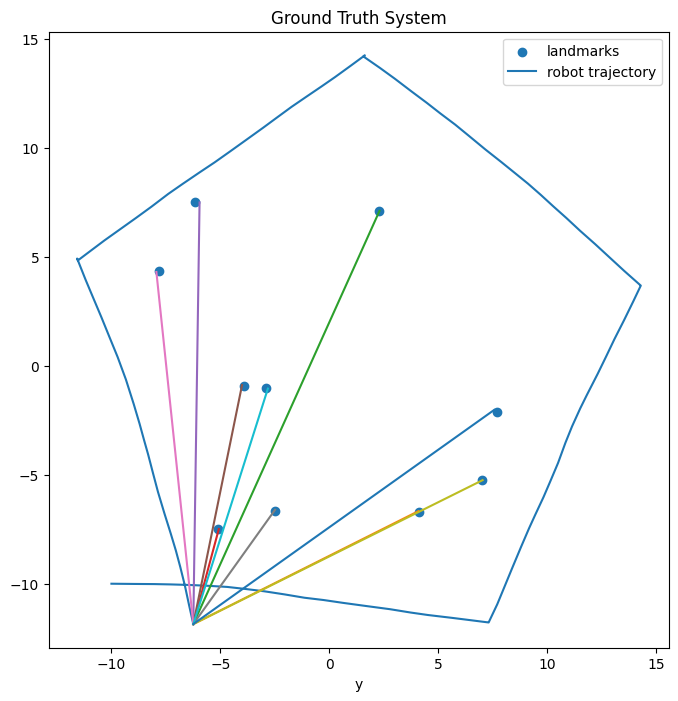

In [306]:
from example_systems import generate_SLAM_system
from helpers import vec

num_landmarks = 10
SLAM_system_gt = generate_SLAM_system(num_landmarks)

landmarks_gt = np.random.uniform(-8, 8, size=(2, num_landmarks))

T = 100
timesteps = np.arange(T) * SLAM_system_gt.delta_t

states_gt = np.zeros((T, 3 + 2*num_landmarks, 1))
controls = np.zeros((T, 3, 1))
measurements = np.zeros((T, 2*num_landmarks, 1))

# initial robot pose and true landmark locations
states_gt[0] = np.vstack([vec(-10.0, -10.0, 0.0), np.vstack(landmarks_gt.T.ravel())])

# robot control sequence
for i in range(5):  # drive in a pentagon
    controls[20*i:20*(i+1)] = vec(0.0, 0.9, 0.0)     # drive straight
    controls[20*i] = vec(2*np.pi/5, 0.0, 0.0)      # turn


for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = SLAM_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = SLAM_system_gt.query_measurement_model(x_next)
    measurements[t] = z

# Plot results
plt.figure(figsize=(8, 8))
plt.title("Ground Truth System")
plt.xlabel("x")
plt.xlabel("y")
plt.axis("equal")
plt.scatter(landmarks_gt[0], landmarks_gt[1], label="landmarks")
plt.plot(states_gt[:,0,0], states_gt[:,1,0], label="robot trajectory")

# plot some measurements
t = T-1
for i in range(num_landmarks):
    px, py, theta = states_gt[t,:3,0]
    b, r = measurements[t,2*i,0], measurements[t,2*i+1,0]
    plt.plot([px, px + r*np.cos(theta + b)], [py, py + r*np.sin(theta + b)])

plt.legend()

In [307]:
# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
SLAM_system_approx = deepcopy(SLAM_system_gt)

In [308]:
# Initial belief
initial_pose_estimate = states_gt[0,:3]
initial_pose_covariance = 0.001*np.eye(3)

# initial_landmarks_estimate = landmarks_gt.T.ravel().reshape(-1,1) + np.random.normal(0, 5.0, size=(2*num_landmarks, 1))
initial_landmarks_estimate = np.zeros((2*num_landmarks, 1))
initial_landmarks_covariance = 100*np.eye(2*num_landmarks)

initial_state_estimate = (
    np.vstack([initial_pose_estimate, initial_landmarks_estimate]),                     # initial mean
    scipy.linalg.block_diag(initial_pose_covariance, initial_landmarks_covariance)      # initial covariance
)

In [309]:
def plot_filter_results(means, filter_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    t = T-1
    ax.set_title(f"Filter Results: {filter_name}")
    ax.set_xlabel("x")
    ax.set_xlabel("y")
    ax.axis("equal")
    ax.plot(states_gt[:t,0,0], states_gt[:t,1,0], label="robot trajectory")
    ax.plot(means[:t,0,0], means[:t,1,0], linestyle="--", label="robot trajectory estimate")
    ax.scatter(landmarks_gt[0], landmarks_gt[1], label="landmarks")
    ax.scatter(means[t, 3::2], means[t, 4::2], marker="x", label=f"landmarks estimate (t={t})")
    ax.legend(loc="upper right")

100%|██████████| 99/99 [00:00<00:00, 159.42it/s]


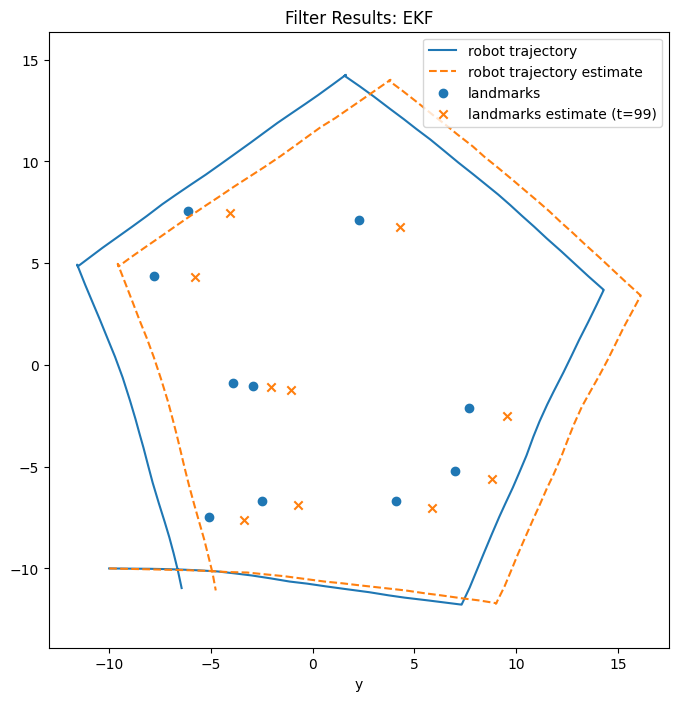

In [310]:
# Run the EKF

from filters import ExtendedKalmanFilter

SLAM_system_EKF = ExtendedKalmanFilter(SLAM_system_approx)

# initial state belief
SLAM_system_EKF.initialize(*initial_state_estimate)

means_EKF = np.zeros((T, SLAM_system_approx.state_dim, 1))
covariances_EKF = np.zeros((T, SLAM_system_approx.state_dim, SLAM_system_approx.state_dim))

means_EKF[0] = SLAM_system_EKF.mean
covariances_EKF[0] = SLAM_system_EKF.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    SLAM_system_EKF.predict_step(u)
    SLAM_system_EKF.update_step(z)

    means_EKF[t] = SLAM_system_EKF.mean
    covariances_EKF[t] = SLAM_system_EKF.covariance

# Plot results
plot_filter_results(means_EKF, "EKF")

100%|██████████| 99/99 [00:00<00:00, 169.83it/s]


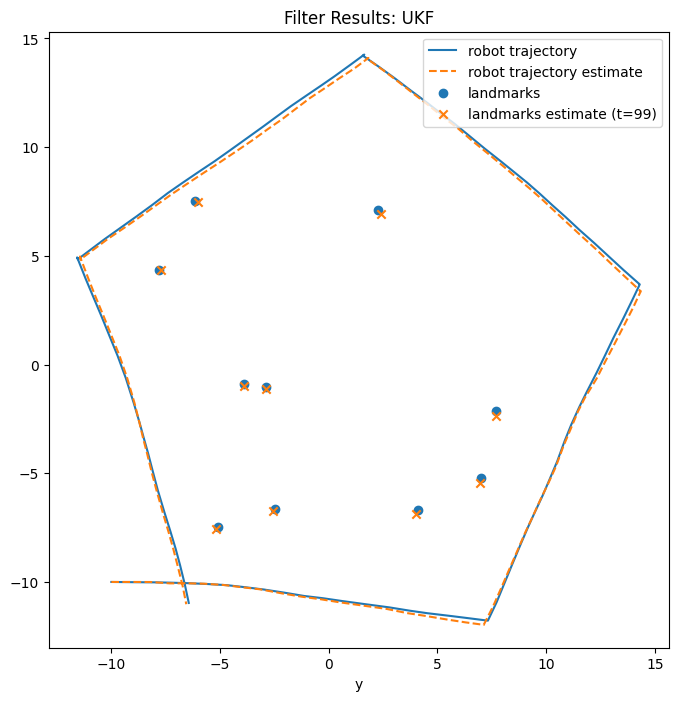

In [311]:
# Run the UKF

from filters import UnscentedKalmanFilter
from probability.sigma_points import StandardSigmaPointSelector, MultiShellSigmaPointSelector


SLAM_system_UKF = UnscentedKalmanFilter(
    SLAM_system_approx,
    StandardSigmaPointSelector()
)

# initial state belief
SLAM_system_UKF.initialize(*initial_state_estimate)

means_UKF = np.zeros((T, SLAM_system_approx.state_dim, 1))
covariances_UKF = np.zeros((T, SLAM_system_approx.state_dim, SLAM_system_approx.state_dim))

means_UKF[0] = SLAM_system_UKF.mean
covariances_UKF[0] = SLAM_system_UKF.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    SLAM_system_UKF.predict_step(u)
    SLAM_system_UKF.update_step(z)

    means_UKF[t] = SLAM_system_UKF.mean
    covariances_UKF[t] = SLAM_system_UKF.covariance

# Plot results
plot_filter_results(means_UKF, "UKF")

100%|██████████| 99/99 [00:01<00:00, 55.78it/s]


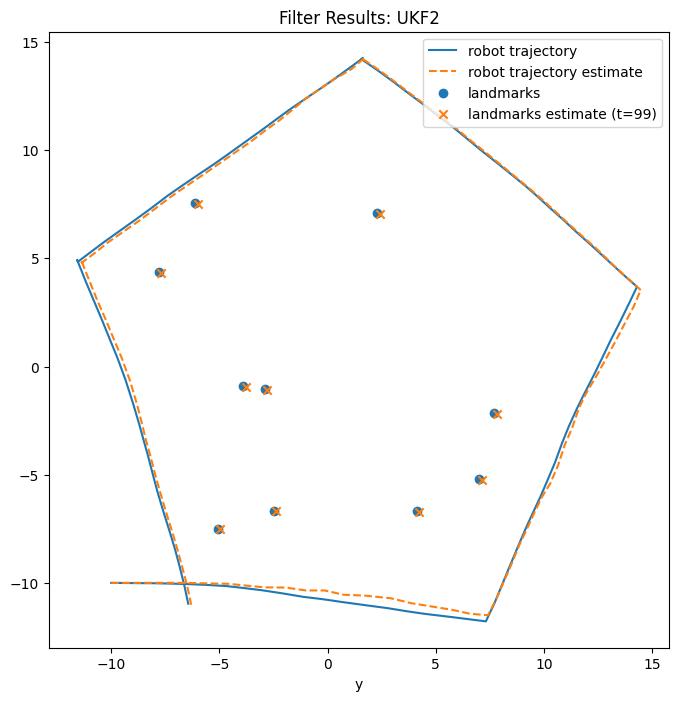

In [312]:
# Run the UKF Variant

SLAM_system_UKF2 = UnscentedKalmanFilter(
    SLAM_system_approx,
    MultiShellSigmaPointSelector([0.1, 0.4, 0.8])
)

# initial state belief
SLAM_system_UKF2.initialize(*initial_state_estimate)

means_UKF2 = np.zeros((T, SLAM_system_approx.state_dim, 1))
covariances_UKF2 = np.zeros((T, SLAM_system_approx.state_dim, SLAM_system_approx.state_dim))

means_UKF2[0] = SLAM_system_UKF2.mean
covariances_UKF2[0] = SLAM_system_UKF2.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    SLAM_system_UKF2.predict_step(u)
    SLAM_system_UKF2.update_step(z)

    means_UKF2[t] = SLAM_system_UKF2.mean
    covariances_UKF2[t] = SLAM_system_UKF2.covariance

# Plot results
plot_filter_results(means_UKF2, "UKF2")

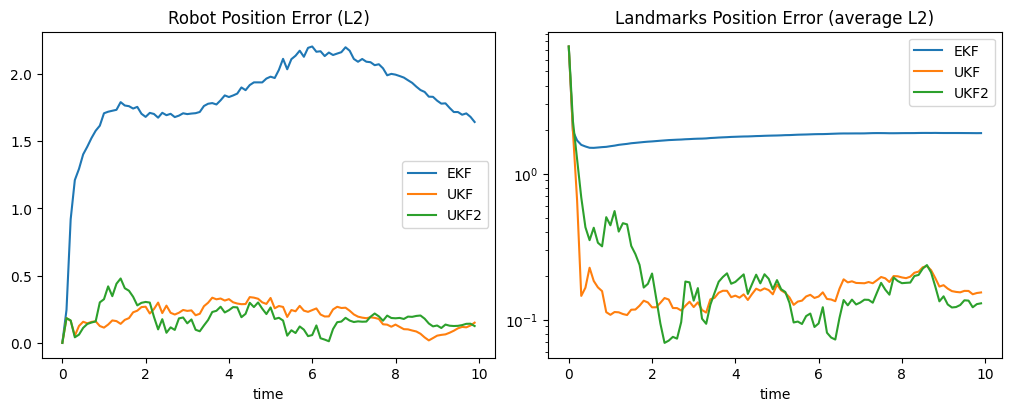

In [313]:
# Error analysis

errors_EKF = means_EKF - states_gt
errors_UKF = means_UKF - states_gt
errors_UKF2 = means_UKF2 - states_gt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

ax1.set_title("Robot Position Error (L2)")
ax1.set_xlabel("time")
ax1.plot(timesteps, np.sqrt(errors_EKF[:, 0]**2 + errors_EKF[:, 1]**2), label="EKF")
ax1.plot(timesteps, np.sqrt(errors_UKF[:, 0]**2 + errors_UKF[:, 1]**2), label="UKF")
ax1.plot(timesteps, np.sqrt(errors_UKF2[:, 0]**2 + errors_UKF2[:, 1]**2), label="UKF2")
ax1.legend()

ax2.set_title("Landmarks Position Error (average L2)")
ax2.set_xlabel("time")
ax2.plot(timesteps, np.mean(np.sqrt(errors_EKF[:, 3::2]**2 + errors_EKF[:, 4::2]**2), axis=1), label="EKF")
ax2.plot(timesteps, np.mean(np.sqrt(errors_UKF[:, 3::2]**2 + errors_UKF[:, 4::2]**2), axis=1), label="UKF")
ax2.plot(timesteps, np.mean(np.sqrt(errors_UKF2[:, 3::2]**2 + errors_UKF2[:, 4::2]**2), axis=1), label="UKF2")
ax2.set_yscale("log")
ax2.legend()

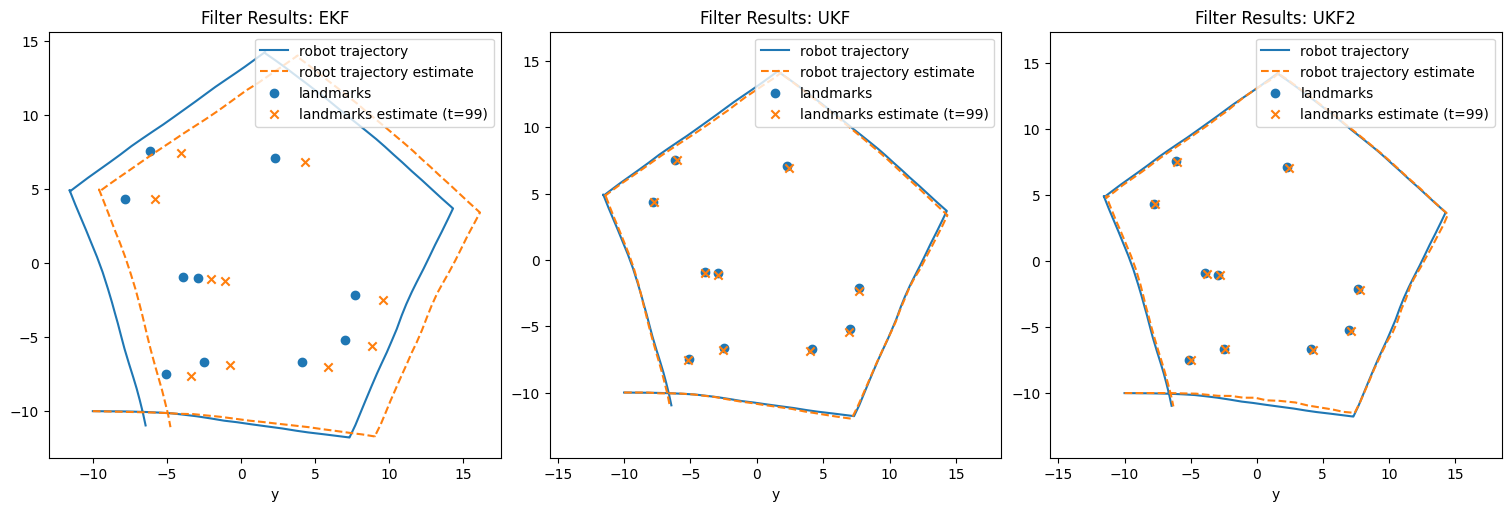

In [314]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

plot_filter_results(means_EKF, "EKF", ax=ax1)
plot_filter_results(means_UKF, "UKF", ax=ax2)
plot_filter_results(means_UKF2, "UKF2", ax=ax3)

In [316]:
from animate_SLAM import animate_SLAM_system

plt.rcParams["animation.html"] = "html5"

fig, ax = plt.subplots(figsize=(8, 8))

ani = animate_SLAM_system(fig, ax,
    means_UKF2[:,:3,0],
    means_UKF2[:,3:,0].reshape(-1, num_landmarks, 2),
    covariances_UKF2[:,:3,:3],
    np.swapaxes(np.stack([
        covariances_UKF2[:, 3+2*i:3+2*(i+1), 3+2*i:3+2*(i+1)]
        for i in range(num_landmarks)
    ]), 0, 1),
    states_gt[:,:3,0],
    states_gt[0,3:,0].reshape(num_landmarks, 2),
    n_std=5,
    title=r"Filter SLAM: UKF2 with $\alpha = 0.1, 0.4, 0.8$ ($5\sigma$ shown)"
)

ani.save("../../figures/nonlinear-2D-SLAM-UKF2.mp4")